# Custom Simulator

This example shows how to use Torch-EPG-X to implement a simulator.


First, we want to implement the simulation engine.
Parallelization and automatic differentiation are abstracted
away from the user, which can focus on implementing single-voxel
simulation.

In [1]:
# imports
from epgtorchx import base
from epgtorchx import ops

class SSFPMRF(base.BaseSimulator):
    """Class to simulate inversion-prepared (variable flip angle) SSFP."""

    @staticmethod
    def sequence(flip, TR, T1, T2, states, signal):
        
        # get number of frames and echoes
        device = flip.device
        npulses = flip.shape[0]

        # define operators
        # preparation
        InvPulse = ops.RFPulse(device, alpha=180.0)
        Crusher = ops.Spoil()
        Prep = ops.CompositeOperator(Crusher, InvPulse)

        # readout
        RF = ops.RFPulse(device) # excitation
        E = ops.Relaxation(device, TR, T1, T2) # relaxation until TR
        S = ops.Shift() # gradient spoil
        
        # Apply preparation
        states = Prep(states)
    
        # actual sequence loop
        for n in range(npulses):
            # apply pulse
            states = RF(states, flip[n])

            # record signal
            signal[n] = ops.observe(states)

            # relax, recover and spoil
            states = E(states)
            states = S(states)

        return signal

The simulator is derived from base class.
`sequence` method must finish with states and signal buffers here.

We can wrap this class in a function, for user convenience:

In [2]:
def mrf(flip, TR, T1, T2, diff=None, device="cpu"):
    """
    Simulate an inversion-prepared SSFP sequence with variable flip angles.

    Args:
        flip (array-like): Flip angle in [deg] of shape (npulses,).
        TR (float): Repetition time in [ms].
        T1 (float, array-like): Longitudinal relaxation time in [ms].
        T2 (float, array-like): Transverse relaxation time in [ms].
        diff (optional, str, tuple[str]): Arguments to get the signal derivative with respect to.
            Defaults to None (no differentation).
        device (optional, str): Computational device. Defaults to "cpu".
    """
    # initialize simulator
    simulator = SSFPMRF(T1=T1, T2=T2, device=device, diff=diff)
            
    # run simulator
    if diff:
        # actual simulation
        sig, dsig = simulator(flip=flip, TR=TR)
        return sig.detach().cpu().numpy(), dsig.detach().cpu().numpy()

    else:
        # actual simulation
        sig = simulator(flip=flip, TR=TR)
        return sig.cpu().numpy()

That's it!
The simulator can be used on single voxel, to quickly predict signal evolution:

Text(0, 0.5, 'signal magnitude [a.u.]')

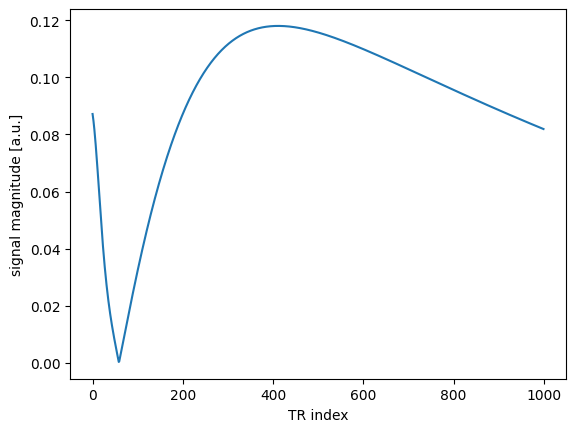

In [3]:
import numpy as np
import matplotlib.pyplot as plt

flip = np.linspace(5.0, 60.0, 1000)
sig = mrf(flip, 10.0, 1000.0, 100.0)

plt.plot(abs(sig))
plt.xlabel("TR index")
plt.ylabel("signal magnitude [a.u.]")

We also support parallelization, with automatic broadcasting:

Text(0, 0.5, 'signal magnitude [a.u.]')

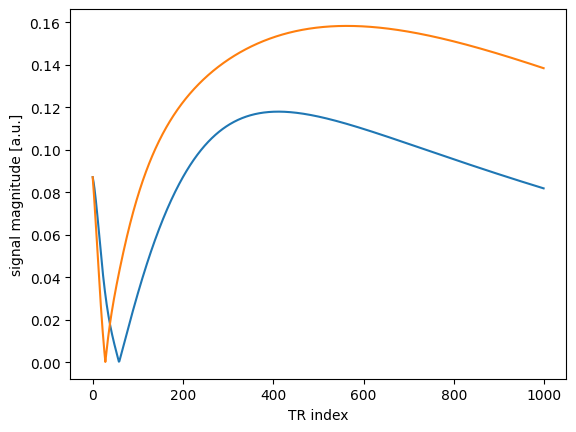

In [4]:
sig = mrf(flip, 10.0, [1000.0, 500.0], 100.0)

plt.plot(abs(sig.T))
plt.xlabel("TR index")
plt.ylabel("signal magnitude [a.u.]")

Automatic differentiation can be obtained by
providing "diff" argument:

Text(0, 0.5, 'signal jacobian [a.u.]')

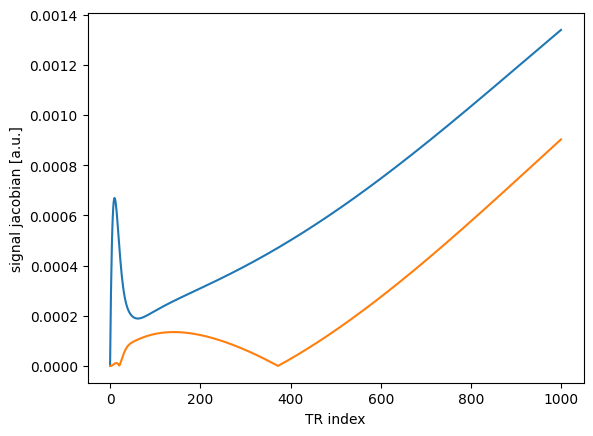

In [5]:
sig, jac = mrf(flip, 10.0, 100.0, 100.0, diff=("T1", "T2"))

plt.plot(abs(jac.T))
plt.xlabel("TR index")
plt.ylabel("signal jacobian [a.u.]")